<a href="https://colab.research.google.com/github/Yussefayman/AI-ART/blob/main/ClipModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
print("Downloading CLIP and installing requirements")
!git clone https://github.com/openai/CLIP                 &> /dev/null
!pip install -q  ftfy regex tqdm omegaconf pytorch-lightning &> /dev/null

In [2]:
from CLIP import clip
import torch
from torchvision import transforms
import torch.nn.functional as F
from tqdm.notebook import tqdm

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu' )
perceptor = clip.load('ViT-B/32',jit=False)[0].eval().requires_grad_(False).to(device)
print(perceptor.visual.input_resolution)

100%|███████████████████████████████████████| 338M/338M [00:08<00:00, 40.9MiB/s]


224


In [ ]:
text_embed = perceptor.encode_text(clip.tokenize('A picnic on the river side').to(device)).float()
text_embed.shape

torch.Size([1, 512])

In [4]:
im = torch.rand(1,3,224,224)
normalize = transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],std=[0.26862954, 0.26130258, 0.27577711])
image_embed = perceptor.encode_image(normalize(im).to(device)).float()
image_embed.shape

torch.Size([1, 512])

In [5]:
def clip_loss_basic(im,text_embed):
  image_embed = perceptor.encode_image(normalize(im).to(device)).float()
  loss = torch.mean((image_embed-text_embed)**2)**0.5
  return loss
clip_loss_basic(im,text_embed)

tensor(0.5414, device='cuda:0')

  0%|          | 0/200 [00:00<?, ?it/s]

0 tensor(0.5210, device='cuda:0', grad_fn=<PowBackward0>)
50 tensor(0.3216, device='cuda:0', grad_fn=<PowBackward0>)
100 tensor(0.2928, device='cuda:0', grad_fn=<PowBackward0>)
150 tensor(0.2805, device='cuda:0', grad_fn=<PowBackward0>)


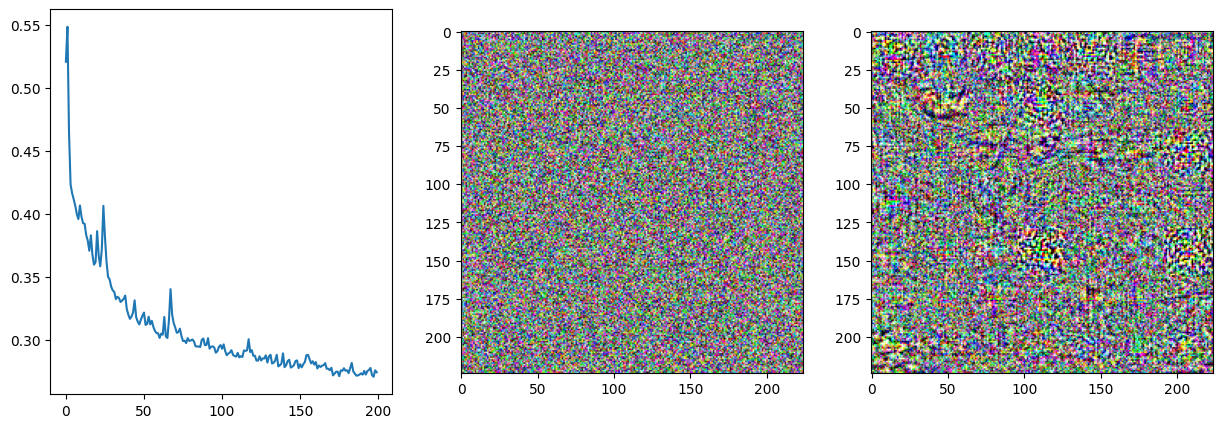

In [6]:
import matplotlib.pyplot as plt
text_embed = perceptor.encode_text(clip.tokenize('A picnic on the river side').to(device)).float()
im = torch.rand(1,3,224,224)
im.requires_grad = True
start_im = im.detach().clone()

optimizer = torch.optim.AdamW([im],lr=7,eps = 1e-3,weight_decay=1e-3)
losses = []
for i in tqdm(range(500)):
  optimizer.zero_grad()
  loss = clip_loss_basic(im,text_embed)
  if i % 50 == 0:
    print(i,loss)
  losses.append(loss.detach().item())
  loss.backward()
  optimizer.step()

fig,axs = plt.subplots(1,3,figsize=(15,5))
axs[0].plot(losses)
axs[1].imshow(start_im.squeeze().permute(1,2,0))
axs[2].imshow(im.squeeze().detach().permute(1,2,0))



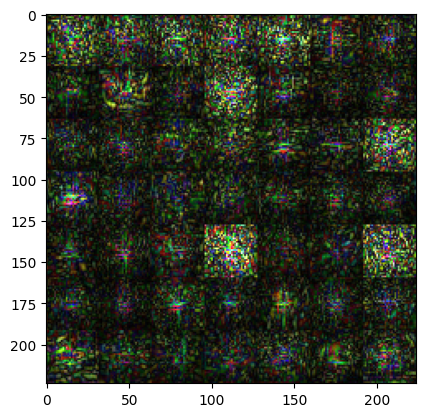

In [7]:
plt.imshow(torch.abs(im.detach()-start_im).squeeze().permute(1,2,0))

  0%|          | 0/1000 [00:00<?, ?it/s]

0 tensor(0.9349, device='cuda:0', grad_fn=<MeanBackward0>)
50 tensor(0.9109, device='cuda:0', grad_fn=<MeanBackward0>)
100 tensor(0.8365, device='cuda:0', grad_fn=<MeanBackward0>)
150 tensor(0.7668, device='cuda:0', grad_fn=<MeanBackward0>)
200 tensor(0.9120, device='cuda:0', grad_fn=<MeanBackward0>)
250 tensor(0.7471, device='cuda:0', grad_fn=<MeanBackward0>)
300 tensor(0.7076, device='cuda:0', grad_fn=<MeanBackward0>)
350 tensor(0.7102, device='cuda:0', grad_fn=<MeanBackward0>)
400 tensor(0.7171, device='cuda:0', grad_fn=<MeanBackward0>)
450 tensor(0.6982, device='cuda:0', grad_fn=<MeanBackward0>)
500 tensor(0.6932, device='cuda:0', grad_fn=<MeanBackward0>)
550 tensor(0.6911, device='cuda:0', grad_fn=<MeanBackward0>)
600 tensor(0.6859, device='cuda:0', grad_fn=<MeanBackward0>)
650 tensor(0.6882, device='cuda:0', grad_fn=<MeanBackward0>)
700 tensor(0.6860, device='cuda:0', grad_fn=<MeanBackward0>)
750 tensor(0.7028, device='cuda:0', grad_fn=<MeanBackward0>)
800 tensor(0.6709, device='

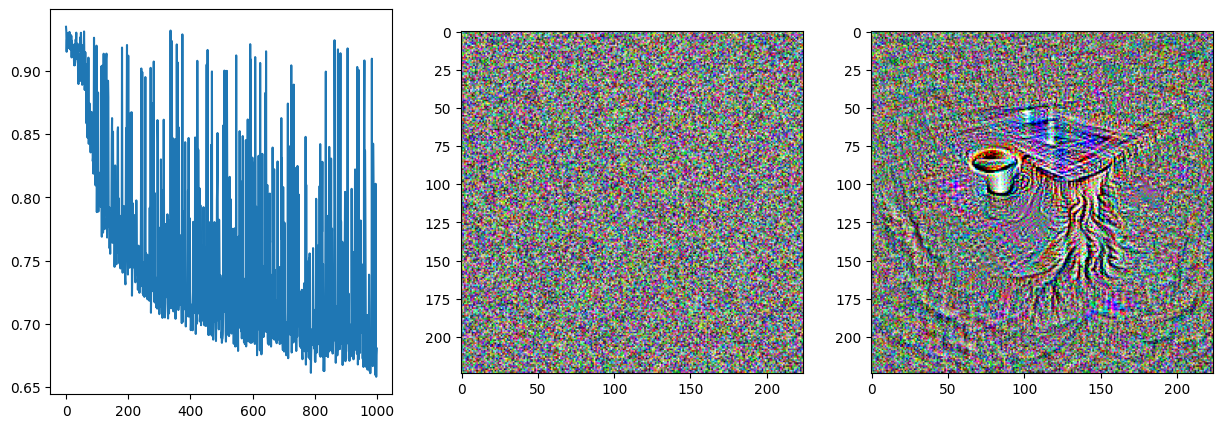

In [28]:
tfms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomAffine(5),
    transforms.ColorJitter(),
    transforms.GaussianBlur(5),
])

def clip_loss(im,text_embed):
  image_embed = perceptor.encode_image(tfms(im).to(device)).float()
  input_normed = F.normalize(image_embed.unsqueeze(1),dim=2)
  embed_normed = F.normalize(text_embed.unsqueeze(0),dim=2)
  # Squared Great Circle Distance
  dists = input_normed.sub(embed_normed).norm(dim=2).div(2).arcsin().pow(2).mul(2)
  return dists.mean()

prompt = 'A cup of coffee on the table'
text_embed = perceptor.encode_text(clip.tokenize(prompt).to(device)).float()

im = torch.rand(1,3,224,224)
im.requires_grad = True
start_im = im.detach().clone()

learning_rate = 0.05
optimizer = torch.optim.AdamW([im],lr=learning_rate,weight_decay=1e-3,eps = 1e-3,betas = (0.8,0.99))
losses = []
n_iterations = 1000
for i in tqdm(range(n_iterations)):
  optimizer.zero_grad()
  loss = clip_loss(im.clip(0,1),text_embed)
  if i % 50 == 0:
    print(i, loss)
  losses.append(loss.detach().item())
  loss.backward()
  optimizer.step()

fig,axs = plt.subplots(1,3,figsize=(15,5))
axs[0].plot(losses)
axs[1].imshow(start_im.squeeze().permute(1,2,0))
axs[2].imshow(im.squeeze().detach().permute(1,2,0))






In [36]:
print("Downloading CLIP and installing requirements")
!git clone https://github.com/openai/CLIP                 &> /dev/null
!pip install -q  ftfy regex tqdm omegaconf pytorch-lightning fastprogress kornia &> /dev/null

In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim

import kornia.augmentation as K
from CLIP import clip
from torchvision import transforms

from PIL import Image
import numpy as np
import math

from matplotlib import pyplot as plt
from fastprogress.fastprogress import master_bar, progress_bar
from IPython.display import HTML
from base64 import b64encode
import warnings
warnings.filterwarnings('ignore')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [52]:
def sinc(x):
  return torch.where(x!=0,torch.sin(math.pi*x) / (math.pi *x),x.new_ones([]))

def lanczos(x,a):
  cond = torch.logical_and(-a <x, x < a)
  out = torch.where(cond,sinc(x)*sinc(x/a), x.new_zeros([]))
  return out / out.sum()

def ramp(ratio,width):
  n = math.ceil(width/ratio + 1)
  out = torch.empty([n])
  cur = 0
  for i in range(out.shape[0]):
    out[i] = cur
    cur+=ratio
  return torch.cat([-out[1:].flip([0]),out])[1:-1]

class Prompt(nn.Module):
  def __init__(self,embed,weight = 1.,stop=float('-inf')):
    super().__init__()
    self.register_buffer('embed',embed)
    self.register_buffer('weight',torch.as_tensor(weight))
    self.register_buffer('stop',torch.as_tensor(stop))

  def forward(self,input):
    input_normed = F.normalize(input.unsqueeze(1),dim=2)
    embed_normed = F.normalize(self.embed.unsqueeze(0),dim=2)
    dists = input_normed.sub(embed_normed).norm(dim=2).div(2).arcsin().pow(2).mul(2)
    dists*=self.weight.sign()
    return self.weight.abs() * replace_grad(dists, torch.maximum(dists, self.stop)).mean()

class MakeCutouts(nn.Module):
  def __init__(self,cut_size,cutn,cut_pow=1.):
    super().__init__()
    self.cut_size = cut_size
    self.cutn = cutn
    self.cut_pow = cut_pow
    self.augs = nn.Sequential(
        K.RandomHorizontalFlip(p = 0.5),
        K.RandomSharpness(0.3,p=0.4),
        K.RandomAffine(degrees=30, translate=0.1, p=0.8, padding_mode='border'),
        K.RandomPerspective(0.2,p=0.4),
        K.ColorJitter(hue=0.01,saturation=0.01,p=0.8)
    )
    self.noise_fac = 0.1
  def forward(self,input):
    sideY, sideX = input.shape[2:4]
    max_size = min(sideX, sideY)
    min_size = min(sideX, sideY, self.cut_size)
    cutouts = []
    for _ in range(self.cutn):
        size = int(torch.rand([])**self.cut_pow * (max_size - min_size) + min_size)
        offsetx = torch.randint(0, sideX - size + 1, ())
        offsety = torch.randint(0, sideY - size + 1, ())
        cutout = input[:, :, offsety:offsety + size, offsetx:offsetx + size]
        cutouts.append(resample(cutout, (self.cut_size, self.cut_size)))
    batch = self.augs(torch.cat(cutouts, dim=0))
    if self.noise_fac:
        facs = batch.new_empty([self.cutn, 1, 1, 1]).uniform_(0, self.noise_fac)
        batch = batch + facs * torch.randn_like(batch)
    return batch


def resample(input, size, align_corners=True):
    n, c, h, w = input.shape
    dh, dw = size

    input = input.view([n * c, 1, h, w])

    if dh < h:
        kernel_h = lanczos(ramp(dh / h, 2), 2).to(input.device, input.dtype)
        pad_h = (kernel_h.shape[0] - 1) // 2
        input = F.pad(input, (0, 0, pad_h, pad_h), 'reflect')
        input = F.conv2d(input, kernel_h[None, None, :, None])

    if dw < w:
        kernel_w = lanczos(ramp(dw / w, 2), 2).to(input.device, input.dtype)
        pad_w = (kernel_w.shape[0] - 1) // 2
        input = F.pad(input, (pad_w, pad_w, 0, 0), 'reflect')
        input = F.conv2d(input, kernel_w[None, None, None, :])

    input = input.view([n, c, h, w])
    return F.interpolate(input, size, mode='bicubic', align_corners=align_corners)

class ReplaceGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x_forward, x_backward):
        ctx.shape = x_backward.shape
        return x_forward

    @staticmethod
    def backward(ctx, grad_in):
        return None, grad_in.sum_to_size(ctx.shape)


replace_grad = ReplaceGrad.apply

In [46]:
perceptor = clip.load('ViT-B/32', jit=False)[0].eval().requires_grad_(False).to(device)
normalize = transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                                 std=[0.26862954, 0.26130258, 0.27577711])
cut_size = perceptor.visual.input_resolution
cutn=64
cut_pow=1
make_cutouts = MakeCutouts(cut_size, cutn, cut_pow=cut_pow)

In [47]:
class ImStack(nn.Module):
  """ This class represents an image as a series of stacked arrays, where each is 1/2
  the resolution of the next. This is useful eg when trying to create an image to minimise
  some loss - parameters in the early (small) layers can have an affect on the overall
  structure and shapes while those in later layers act as residuals and fill in fine detail.
  """

  def __init__(self, n_layers=4, base_size=32, scale=2,
               init_image=None, out_size=256, decay=0.7):
    """Constructs the Image Stack

    Args:
        n_layers: How many layers in the stack
        base_size: The size of the smallest layer
        scale: how much larger each subsequent layer is
        init_image: Pass in a PIL image if you don't want to start from noise
        out_size: The output size. Works best if output size ~= base_size * (scale ** (n_layers-1))
        decay: When initializing with noise, decay controls scaling of later layers (avoiding too miuch high-frequency noise)

    """
    super().__init__()
    self.n_layers = n_layers
    self.base_size = base_size
    self.sig = nn.Sigmoid()
    self.layers = []

    for i in range(n_layers):
        side = base_size * (scale**i)
        tim = torch.randn((3, side, side)).to(device)*(decay**i)
        self.layers.append(tim)

    self.scalers = [nn.Upsample(scale_factor=out_size/(l.shape[1]), mode='bilinear', align_corners=False) for l in self.layers]

    self.preview_scalers = [nn.Upsample(scale_factor=224/(l.shape[1]), mode='bilinear', align_corners=False) for l in self.layers]

    if init_image != None: # Given a PIL image, decompose it into a stack
      downscalers = [nn.Upsample(scale_factor=(l.shape[1]/out_size), mode='bilinear', align_corners=False) for l in self.layers]
      final_side = base_size * (scale ** n_layers)
      im = torch.tensor(np.array(init_image.resize((out_size, out_size)))/255).clip(1e-03, 1-1e-3) # Between 0 and 1 (non-inclusive)
      im = im.permute(2, 0, 1).unsqueeze(0).to(device) # torch.log(im/(1-im))
      for i in range(n_layers):self.layers[i] *= 0 # Sero out the layers
      for i in range(n_layers):
        side = base_size * (scale**i)
        out = self.forward()
        residual = (torch.logit(im) - torch.logit(out))
        Image.fromarray((torch.logit(residual).detach().cpu().squeeze().permute([1, 2, 0]) * 255).numpy().astype(np.uint8)).save(f'residual{i}.png')
        self.layers[i] = downscalers[i](residual).squeeze()

    for l in self.layers: l.requires_grad = True

  def forward(self):
    """Sums the stacked layers (upsampling them all to out_size) and then runs the result through a sigmoid funtion."""
    im = self.scalers[0](self.layers[0].unsqueeze(0))
    for i in range(1, self.n_layers):
      im += self.scalers[i](self.layers[i].unsqueeze(0))
    return self.sig(im)

  def preview(self, n_preview=2):
    """Useful if you want to optimise the first few layers first"""
    im = self.preview_scalers[0](self.layers[0].unsqueeze(0))
    for i in range(1, n_preview):
      im += self.preview_scalers[i](self.layers[i].unsqueeze(0))
    return self.sig(im)

  def to_pil(self):
    """Return it as a PIL Image (useful for saving, transforming, viewing etc)"""
    return Image.fromarray((self.forward().detach().cpu().squeeze().permute([1, 2, 0]) * 255).numpy().astype(np.uint8))

  def preview_pil(self):
    return Image.fromarray((self.preview().detach().cpu().squeeze().permute([1, 2, 0]) * 255).numpy().astype(np.uint8))

  def save(self, fn):
    self.to_pil().save(fn)

  def plot_layers(self):
    """View the layers in the stack - nice to build intuition about what's happening."""
    fig, axs = plt.subplots(1, self.n_layers, figsize=(15, 5))
    for i in range(self.n_layers):
      im = (self.sig(self.layers[i].unsqueeze(0)).detach().cpu().squeeze().permute([1, 2, 0]) * 255).numpy().astype(np.uint8)
      axs[i].imshow(im)

In [48]:
ims = ImStack()

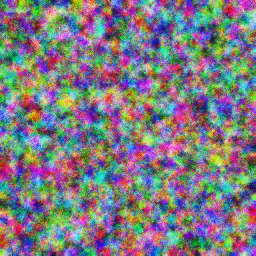

In [49]:
ims.to_pil()

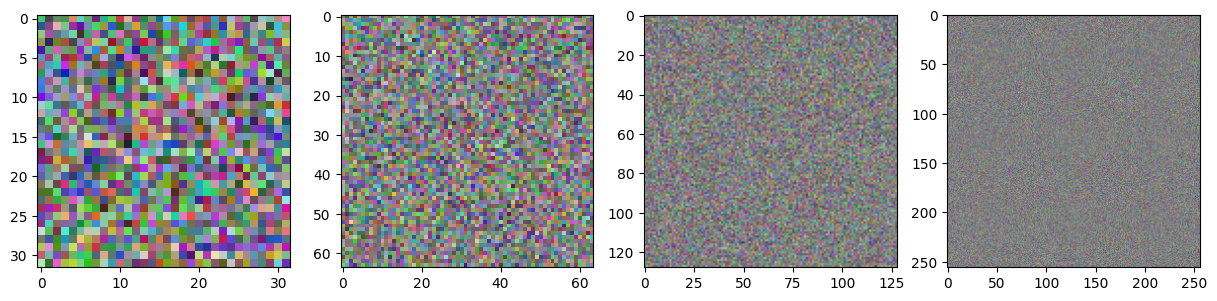

In [50]:
ims = ImStack()
ims.plot_layers()

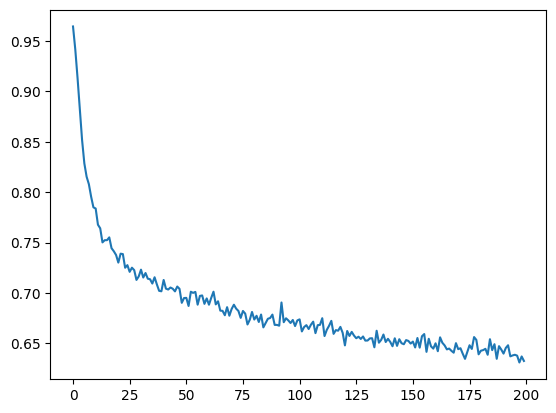

In [58]:
embed = perceptor.encode_text(clip.tokenize('A picnic on the river side').to(device)).float()
prompt = Prompt(embed, 1, float('-inf')).to(device)

# The ImStack. Layer sizes will be 16, 32, 64, 128, 256 and 512
ims = ImStack(base_size=16, scale=2, n_layers=6, out_size=512, decay=0.4)

# An optimizer (you can try others) with the image layers as parameters
optimizer = optim.AdamW(ims.layers, lr=0.3,weight_decay = 1e-6)

# Somewhere to track our losses
losses = []

# A basic progress bar (using fastprogress)
bar = progress_bar(range(200))
for i in bar:
  optimizer.zero_grad()
  im = ims() # Get the image from the ImStack
  iii = perceptor.encode_image(normalize(make_cutouts(im))).float() # Encode image (using multiple cutouts)
  l = prompt(iii) # Calculate loss
  losses.append(float(l.detach().cpu())) # Store loss
  l.backward() # Backprop
  optimizer.step() # Update

plt.plot(losses)

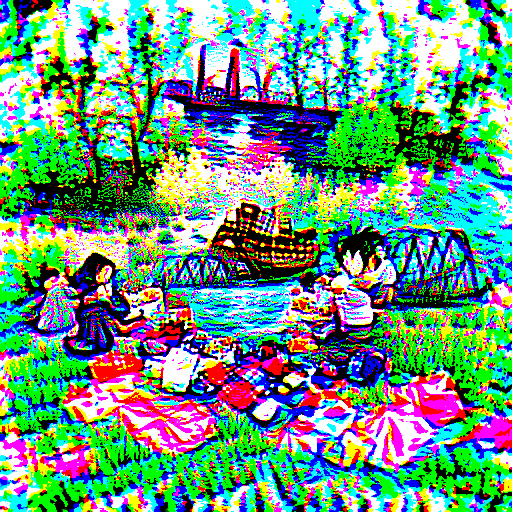

In [59]:
ims.to_pil()

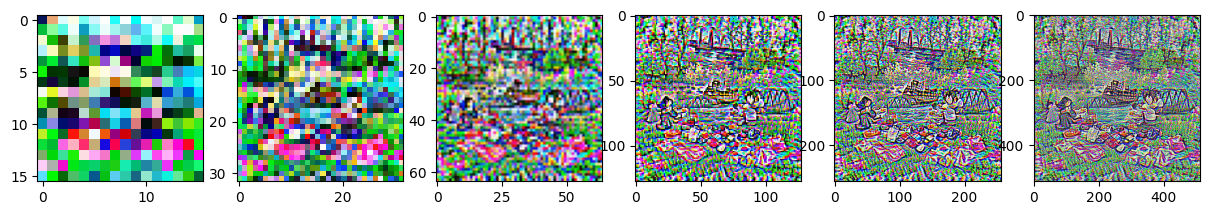

In [60]:
ims.plot_layers()

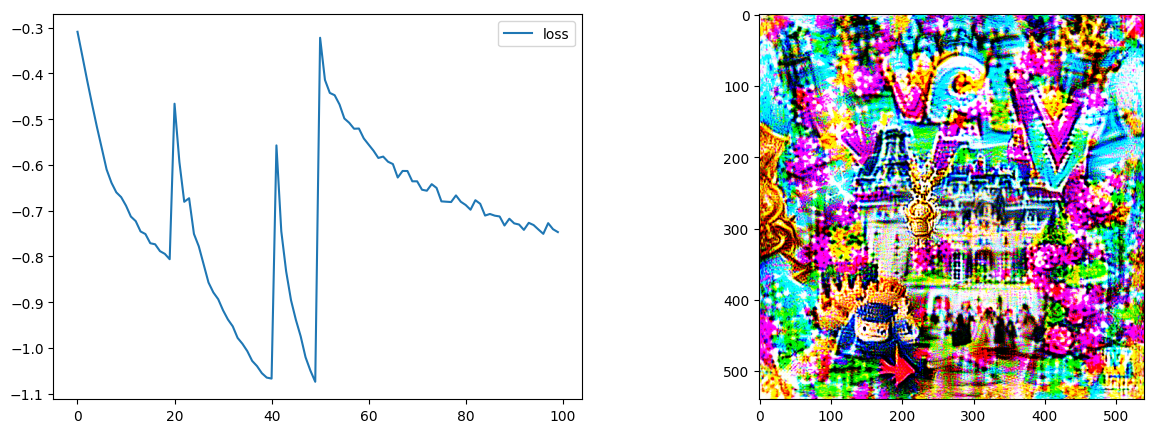

In [68]:
# Somewhere to store images that will be used for the video
!rm -r steps
!mkdir -p steps

# A list of positive prompts
p_prompts = []
for pr in ["Create a vivid interior view of La Versailles Castle, showcasing ornate decor, grand hallways, and majestic chandeliers.",]:
  embed = perceptor.encode_text(clip.tokenize(pr).to(device)).float()
  p_prompts.append(Prompt(embed, 1, float('-inf')).to(device)) # 1 is the weight

# SOme negative prompts
n_prompts = []
for pr in ["Random noise", 'saturated rainbow RGB deep dream','Different Colors']:
  embed = perceptor.encode_text(clip.tokenize(pr).to(device)).float()
  n_prompts.append(Prompt(embed, 0.5, float('-inf')).to(device)) # 0.5 is the weight

# The ImageStack - trying a different scale and n_layers
ims = ImStack(base_size=20, scale=3, n_layers=4, out_size=540, decay=0.4)

optimizer = optim.AdamW(ims.layers, lr=0.3,weight_decay=1e-6)
losses = []

# Some fancier progress bar stuff (this is a little hacky since I stole it from another project of mine that wasn't written for public consumption!)
mb = master_bar(range(1))
mb.names=['loss']
mb.graph_fig, axs = plt.subplots(1, 2, figsize=(15, 5)) # For custom display
mb.graph_ax = axs[0]
mb.img_ax = axs[1]
mb.graph_out = display(mb.graph_fig, display_id=True)

for p in mb:
  for i in progress_bar(range(100), parent=mb):
    optimizer.zero_grad()

    if i < 50: # Save time by skipping the cutouts and focusing on the lower layers
      im = ims.preview(n_preview=1 + i//20 )
      iii = perceptor.encode_image(normalize(im)).float()
    else:
      im = ims()
      iii = perceptor.encode_image(normalize(make_cutouts(im))).float()

    l = 0
    for prompt in p_prompts:
      l += prompt(iii)
    for prompt in n_prompts:
      l -= prompt(iii)

    losses.append(float(l.detach().cpu()))
    l.backward() # Backprop
    optimizer.step() # Update

    # Show progress and loss plot
    mb.update_graph([[range(len(losses)), losses]])

    # View and save images every few iterations
    save_every = 5
    if i % save_every == 0:
      img = ims.to_pil()
      mb.img_ax.imshow(img)
      mb.graph_out.update(mb.graph_fig)
      img.save(f'steps/step{len(losses)//save_every:04}.png')

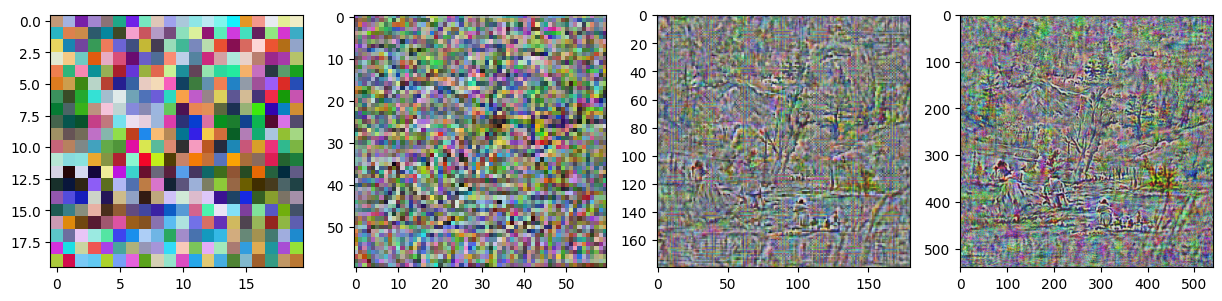

In [62]:
ims.plot_layers()

In [67]:
#@title Generate and View a video of the process:
!ffmpeg -y -v 1 -i steps/step%04d.png -r 24 -vcodec libx264 -crf 32 -pix_fmt yuv420p  temp.mp4
mp4 = open('temp.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)